In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep_paper.simulator import HierarchicalBayesianModel
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [6]:
df

,pulse_amplitude,compound_position,participant,Biceps,Triceps,APB
0,0.0,0,0,0.016175,0.154478,0.014103
1,44.0,0,0,0.019536,0.114382,0.014754
2,88.0,0,0,0.016855,0.164685,0.011458
3,132.0,0,0,0.016967,0.146734,0.016941
4,176.0,0,0,0.013771,0.561963,0.876413
...,...,...,...,...,...,...
895,176.0,0,9,0.028445,0.000122,3.970674
896,224.0,0,9,0.042657,0.151382,6.816915
897,268.0,0,9,0.433376,0.476729,7.085731
898,312.0,0,9,0.950837,0.646506,7.978973


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/simulation.toml")

config = Config(toml_path=toml_path)

model = HierarchicalBayesianModel(config=config)



2023-09-13 11:47:14,283 - hbmep.config - INFO - Verifying configuration ...
2023-09-13 11:47:14,283 - hbmep.config - INFO - Success!
2023-09-13 11:47:14,304 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link


In [3]:
# Load data
simulation_params = {
    "n_subject": 1,
    "n_feature0": 1,
    "n_repeats": 10
}
df_full, posterior_samples_true = model.simulate(**simulation_params)

obs = np.array(posterior_samples_true[site.obs])
df_full[model.response] = obs[0, ...]

df_full.shape

2023-09-13 11:47:14,504 - hbmep.model.baseline - INFO - Simulating data ...


2023-09-13 11:47:16,416 - hbmep.utils.utils - INFO - func:predict took: 1.91 sec
2023-09-13 11:47:16,417 - hbmep.utils.utils - INFO - func:simulate took: 1.91 sec


(90, 4)

In [50]:
from matplotlib.backends.backend_pdf import PdfPages

after_every_space = [20, 15, 10, 1]
n_after_every_space = len(after_every_space)
after_every_counter = 0

nrows, ncols = len(after_every_space), 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

n_fig_rows = 10
n_columns_per_response = 4
n_fig_columns = n_columns_per_response * model.n_response

n_combinations = n_after_every_space
n_pdf_pages = n_combinations // n_fig_rows
if n_combinations % n_fig_rows: n_pdf_pages += 1

dst = os.path.join(model.build_dir, "checks.pdf")
pdf = PdfPages(dst)

for page in range(n_pdf_pages):
    """ No. of rows for current page """
    n_rows_current_page = min(
        n_fig_rows,
        n_combinations - page * n_fig_rows
    )

    """ Figure for current page """
    fig, axes = plt.subplots(
        n_rows_current_page,
        n_fig_columns,
        figsize=(
            n_fig_columns * model.subplot_cell_width,
            n_rows_current_page * model.subplot_cell_height
        ),
        constrained_layout=True,
        squeeze=False,
        sharex="col"
    )

    for i in range(n_rows_current_page):
        after_every = after_every_space[after_every_counter]
        df = df_full.iloc[::after_every].reset_index(drop=True).copy()
        logger.info(df.shape)

        df, encoder_dict = model.load(df=df)

        ax = axes[i, 0]
        sns.scatterplot(x=df[model.intensity], y=df[model.response[0]], ax=ax)

        mcmc, posterior_samples = model.run_inference(df=df)

        pred_df = model._make_prediction_dataset(df=df)
        obs_posterior = model.predict(df=pred_df, posterior_samples=posterior_samples)
        mu_posterior = np.array(obs_posterior[site.mu])
        obs_posterior = np.array(obs_posterior[site.obs])

        """ Filter prediction dataframe based on current combination """
        temp_pred_df = pred_df.copy()

        curr_obs_posterior = obs_posterior
        curr_mu_posterior = mu_posterior

        """ Posterior mean """
        curr_obs_posterior_mean = curr_obs_posterior.mean(axis=0)
        curr_mu_posterior_mean = curr_mu_posterior.mean(axis=0)

        """ HPDI intervals """
        hpdi_obs_95 = hpdi(curr_obs_posterior, prob=.95)
        hpdi_obs_85 = hpdi(curr_obs_posterior, prob=.85)
        hpdi_obs_65 = hpdi(curr_obs_posterior, prob=.65)

        hpdi_mu_95 = hpdi(curr_mu_posterior, prob=.95)

        """ Threshold """
        threshold_posterior = posterior_samples[site.a].reshape(-1,)
        threshold = threshold_posterior.mean()
        threshold_true = posterior_samples_true[site.a][0].reshape(-1,)
        hpdi_interval = hpdi(threshold_posterior, prob=0.95)

        ax = axes[i, 1]
        sns.lineplot(x=temp_pred_df[model.intensity], y=curr_obs_posterior_mean[:, 0], color="k", ax=ax, linestyle="dashed")
        sns.scatterplot(x=df[model.intensity], y=df[model.response[0]], ax=ax)
        # sns.kdeplot(
        #     x=threshold_posterior,
        #     color="b",
        #     ax=ax,
        #     alpha=.4
        # )
        ax.axvline(
            threshold,
            linestyle="--",
            color="r",
            label=f"Predicted Threshold"
        )
        ax.axvline(
            threshold_true,
            linestyle="--",
            color="g",
            label=f"Actual Threshold"
        )
        # ax.axvline(
        #     hpdi_interval[0],
        #     linestyle="--",
        #     color="grey",
        #     label=f"95% HPDI Interval"
        # )
        # ax.axvline(
        #     hpdi_interval[1],
        #     linestyle="--",
        #     color="grey"
        # )
        ax.legend()

        ax = axes[i, 2]
        sns.kdeplot(
            x=threshold_posterior,
            color="b",
            ax=ax,
            alpha=.4
        )
        ax.axvline(
            threshold,
            linestyle="--",
            color="r",
            label=f"Predicted Threshold"
        )
        ax.axvline(
            threshold_true,
            linestyle="--",
            color="g",
            label=f"Actual Threshold"
        )
        # ax.axvline(
        #     hpdi_interval[0],
        #     linestyle="--",
        #     color="grey",
        #     label=f"95% HPDI Interval"
        # )
        # ax.axvline(
        #     hpdi_interval[1],
        #     linestyle="--",
        #     color="grey"
        # )
        ax.legend()

        ax = axes[i, 3]
        sns.lineplot(x=temp_pred_df[model.intensity], y=curr_obs_posterior_mean[:, 0], color="k", ax=ax, linestyle="dashed")
        ax.fill_between(
            temp_pred_df[model.intensity],
            hpdi_mu_95[0, :, 0],
            hpdi_mu_95[1, :, 0],
            color="C1",
            linestyle="dashed"
        )
        sns.scatterplot(
            data=df,
            x=model.intensity,
            y=model.response[0],
            color="y",
            edgecolor="black",
            ax=ax
        )

        after_every_counter += 1

    pdf.savefig(fig)
    plt.close()

plt.close()
pdf.close();


2023-09-13 12:42:32,634 - __main__ - INFO - (5, 4)
2023-09-13 12:42:32,635 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:42:32,635 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:42:32,636 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 12:42:32,637 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-13 12:42:32,646 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 12:42:39,989 - hbmep.utils.utils - INFO - func:run_inference took: 7.34 sec
2023-09-13 12:42:41,160 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
2023-09-13 12:42:41,600 - __main__ - INFO - (6, 4)
2023-09-13 12:42:41,601 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:42:41,602 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:42:41,603 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 12:42:41,604 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-13 12:42:41,616 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 12:42:49,293 - hbmep.utils.utils - INFO - func:run_inference took: 7.68 sec
2023-09-13 12:42:50,467 - hbmep.utils.utils - INFO - func:predict took: 1.17 sec
2023-09-13 12:42:50,908 - __main__ - INFO - (9, 4)
2023-09-13 12:42:50,909 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:42:50,909 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:42:50,910 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 12:42:50,911 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-13 12:42:50,923 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 12:42:58,710 - hbmep.utils.utils - INFO - func:run_inference took: 7.79 sec
2023-09-13 12:42:59,887 - hbmep.utils.utils - INFO - func:predict took: 1.17 sec
2023-09-13 12:43:00,333 - __main__ - INFO - (90, 4)
2023-09-13 12:43:00,334 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:43:00,335 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 12:43:00,336 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 12:43:00,337 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-13 12:43:00,348 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 12:43:39,831 - hbmep.utils.utils - INFO - func:run_inference took: 39.48 sec
2023-09-13 12:43:41,020 - hbmep.utils.utils - INFO - func:predict took: 1.18 sec


In [64]:
np.argmax(hpdi_mu_95[1, ...] - hpdi_mu_95[0, ...])

99

In [62]:
df_full

,participant,compound_position,pulse_amplitude,biceps
0,0,0,0.0,0.004091
1,0,0,4.0,0.002846
2,0,0,8.0,0.000083
3,0,0,12.0,0.000087
4,0,0,16.0,0.001027
...,...,...,...,...
85,0,0,340.0,1.634435
86,0,0,344.0,1.538792
87,0,0,348.0,1.545144
88,0,0,352.0,1.763370


In [59]:
pred_df

,participant,compound_position,pulse_amplitude
0,0,0,0.000000
1,0,0,3.434343
2,0,0,6.868687
3,0,0,10.303030
4,0,0,13.737374
...,...,...,...
95,0,0,326.262626
96,0,0,329.696970
97,0,0,333.131313
98,0,0,336.565657


In [73]:
list(range(0, 90, 30))

[0, 30, 60]

In [228]:
ind = [0, 30, 60, 89]
n_iter = 20
n_after_every_space = n_iter + 1
after_every_counter = 0

n_fig_rows = 10
n_columns_per_response = 4
n_fig_columns = n_columns_per_response * model.n_response

n_combinations = n_iter + 1
n_pdf_pages = n_combinations // n_fig_rows
if n_combinations % n_fig_rows: n_pdf_pages += 1

dst = os.path.join(model.build_dir, "checks.pdf")
pdf = PdfPages(dst)

argmin = None
score_df = None
score_columns = ["num_points", "loo", "waic", "mae", "mse"]

pred_df = df_full.copy()

for page in range(n_pdf_pages):
    """ No. of rows for current page """
    n_rows_current_page = min(
        n_fig_rows,
        n_combinations - page * n_fig_rows
    )

    """ Figure for current page """
    fig, axes = plt.subplots(
        n_rows_current_page,
        n_fig_columns,
        figsize=(
            n_fig_columns * model.subplot_cell_width,
            n_rows_current_page * model.subplot_cell_height
        ),
        constrained_layout=True,
        squeeze=False,
        sharex="col"
    )

    for i in range(n_rows_current_page):
        df = df_full.iloc[ind].reset_index(drop=True).copy()
        logger.info(df.shape)

        df, encoder_dict = model.load(df=df)

        ax = axes[i, 0]
        sns.scatterplot(x=df[model.intensity], y=df[model.response[0]], ax=ax)
        title = f"Num points: {df.shape[0]}"
        ax.set_title(title)

        mcmc, posterior_samples = model.run_inference(df=df)

        obs_posterior = model.predict(df=pred_df, posterior_samples=posterior_samples)
        mu_posterior = np.array(obs_posterior[site.mu])
        obs_posterior = np.array(obs_posterior[site.obs])

        """ Filter prediction dataframe based on current combination """
        temp_pred_df = pred_df.copy()

        curr_mu_posterior = mu_posterior
        curr_obs_posterior = obs_posterior

        """ Posterior mean """
        curr_mu_posterior_mean = curr_mu_posterior.mean(axis=0)
        curr_obs_posterior_mean = curr_obs_posterior.mean(axis=0)

        """ HPDI intervals """
        hpdi_obs_95 = hpdi(curr_obs_posterior, prob=.95)
        hpdi_obs_85 = hpdi(curr_obs_posterior, prob=.85)
        hpdi_obs_65 = hpdi(curr_obs_posterior, prob=.65)

        hpdi_mu_95 = hpdi(curr_mu_posterior, prob=.95)

        """ Threshold """
        threshold_posterior = posterior_samples[site.a].reshape(-1,)
        threshold = threshold_posterior.mean().item()
        threshold_true = posterior_samples_true[site.a][0].reshape(-1,).item()
        hpdi_interval = hpdi(threshold_posterior, prob=0.95)

        """ Scores """
        numpyro_data = az.from_numpyro(mcmc)
        loo_score = az.loo(numpyro_data).elpd_loo
        waic_score = az.waic(numpyro_data).elpd_waic
        mae = abs(threshold_true - threshold)
        mse = mae ** 2

        ax = axes[i, 1]
        sns.lineplot(x=temp_pred_df[model.intensity], y=curr_mu_posterior_mean[:, 0], color="k", ax=ax, linestyle="dashed")
        sns.scatterplot(x=df[model.intensity], y=df[model.response[0]], ax=ax)
        ax.axvline(
            threshold,
            linestyle="--",
            color="r",
            label=f"Predicted Threshold"
        )
        ax.axvline(
            threshold_true,
            linestyle="--",
            color="g",
            label=f"Actual Threshold"
        )
        ax.legend()

        ax = axes[i, 2]
        sns.kdeplot(
            x=threshold_posterior,
            color="b",
            ax=ax,
            alpha=.4
        )
        ax.axvline(
            threshold,
            linestyle="--",
            color="r",
            label=f"Predicted Threshold"
        )
        ax.axvline(
            threshold_true,
            linestyle="--",
            color="g",
            label=f"Actual Threshold"
        )
        ax.legend()

        ax = axes[i, 3]
        sns.lineplot(x=temp_pred_df[model.intensity], y=curr_mu_posterior_mean[:, 0], color="k", ax=ax, linestyle="dashed")
        ax.fill_between(
            temp_pred_df[model.intensity],
            hpdi_mu_95[0, :, 0],
            hpdi_mu_95[1, :, 0],
            color="C1",
            linestyle="dashed"
        )
        sns.scatterplot(
            data=df,
            x=model.intensity,
            y=model.response[0],
            color="y",
            edgecolor="black",
            ax=ax
        )
        title = f"Loo: {loo_score: .2f}, WAIC: {waic_score: .2f}"
        ax.set_title(title)

        score_row = [[df.shape[0], loo_score, waic_score, mae, mse]]
        temp_score_df = pd.DataFrame(score_row, columns=score_columns)
        if score_df is None:
            score_df = temp_score_df.copy()
        else:
            score_df = pd.concat([score_df, temp_score_df])

        ind_filter = sorted(list(set(range(df_full.shape[0])) - set(ind)))
        argmax = np.abs(hpdi_mu_95[:, ind_filter, ...] - curr_mu_posterior_mean[None, ind_filter, ...]).max(axis=0).argmax()
        argmax = ind_filter[argmax]
        ind.append(argmax)
        ind = sorted(ind)

        sns.scatterplot(
            x=[df_full[model.intensity][argmax]],
            y=[df_full[model.response[0]][argmax]],
            color="black",
            edgecolor="black",
            ax=ax
        )

    pdf.savefig(fig)
    plt.close()

nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex="row")

metrics = ["loo", "waic", "mae", "mse"]
for i, metric in enumerate(metrics):
    ax = axes[0, i]
    sns.lineplot(data=score_df, x="num_points", y=metric, marker="o", linestyle="dashed", ms=8, ax=ax)
    ax.set_title(metric)
    ax.set_xticks(score_df["num_points"])

pdf.savefig(fig)
plt.close()

pdf.close();


2023-09-13 16:37:11,375 - __main__ - INFO - (4, 4)
2023-09-13 16:37:11,375 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 16:37:11,375 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 16:37:11,376 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 16:37:11,377 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-13 16:37:11,386 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:37:18,513 - hbmep.utils.utils - INFO - func:run_inference took: 7.13 sec
2023-09-13 16:37:19,610 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior varia

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:37:28,128 - hbmep.utils.utils - INFO - func:run_inference took: 7.95 sec
2023-09-13 16:37:29,221 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior varia

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:37:38,348 - hbmep.utils.utils - INFO - func:run_inference took: 8.54 sec
2023-09-13 16:37:42,257 - hbmep.utils.utils - INFO - func:predict took: 3.91 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:37:42,804 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:37:52,856 - hbmep.utils.utils - INFO - func:run_inference took: 10.04 sec
2023-09-13 16:37:53,960 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:37:54,511 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:38:04,454 - hbmep.utils.utils - INFO - func:run_inference took: 9.93 sec
2023-09-13 16:38:05,547 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:38:06,097 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:38:15,529 - hbmep.utils.utils - INFO - func:run_inference took: 9.42 sec
2023-09-13 16:38:16,629 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:38:17,184 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:38:27,381 - hbmep.utils.utils - INFO - func:run_inference took: 10.18 sec
2023-09-13 16:38:28,523 - hbmep.utils.utils - INFO - func:predict took: 1.14 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:38:29,079 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:38:39,881 - hbmep.utils.utils - INFO - func:run_inference took: 10.79 sec
2023-09-13 16:38:40,983 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:38:41,546 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:38:52,914 - hbmep.utils.utils - INFO - func:run_inference took: 11.35 sec
2023-09-13 16:38:54,005 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:38:54,571 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:39:07,666 - hbmep.utils.utils - INFO - func:run_inference took: 13.08 sec
2023-09-13 16:39:08,757 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:39:11,028 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:39:23,878 - hbmep.utils.utils - INFO - func:run_inference took: 12.84 sec
2023-09-13 16:39:24,988 - hbmep.utils.utils - INFO - func:predict took: 1.11 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:39:25,697 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:39:39,824 - hbmep.utils.utils - INFO - func:run_inference took: 14.11 sec
2023-09-13 16:39:40,917 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:39:41,634 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:39:58,994 - hbmep.utils.utils - INFO - func:run_inference took: 17.34 sec
2023-09-13 16:40:00,104 - hbmep.utils.utils - INFO - func:predict took: 1.11 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:40:00,821 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:40:15,093 - hbmep.utils.utils - INFO - func:run_inference took: 14.26 sec
2023-09-13 16:40:16,199 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:40:16,926 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:40:33,354 - hbmep.utils.utils - INFO - func:run_inference took: 16.41 sec
2023-09-13 16:40:34,447 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:40:35,202 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:40:51,010 - hbmep.utils.utils - INFO - func:run_inference took: 15.79 sec
2023-09-13 16:40:52,103 - hbmep.utils.utils - INFO - func:predict took: 1.09 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:40:52,892 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:41:08,343 - hbmep.utils.utils - INFO - func:run_inference took: 15.44 sec
2023-09-13 16:41:09,442 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:41:10,209 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:41:27,824 - hbmep.utils.utils - INFO - func:run_inference took: 17.60 sec
2023-09-13 16:41:28,933 - hbmep.utils.utils - INFO - func:predict took: 1.11 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:41:29,687 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:41:48,254 - hbmep.utils.utils - INFO - func:run_inference took: 18.55 sec
2023-09-13 16:41:49,362 - hbmep.utils.utils - INFO - func:predict took: 1.11 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:41:50,112 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:42:08,393 - hbmep.utils.utils - INFO - func:run_inference took: 18.27 sec
2023-09-13 16:42:09,509 - hbmep.utils.utils - INFO - func:predict took: 1.11 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 16:42:11,859 - __main__ -

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 16:42:29,331 - hbmep.utils.utils - INFO - func:run_inference took: 17.46 sec
2023-09-13 16:42:30,433 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [223]:
curr_mu_posterior_mean.shape

(100, 1)

In [221]:
df_full

,participant,compound_position,pulse_amplitude,biceps
0,0,0,0.0,0.004091
1,0,0,4.0,0.002846
2,0,0,8.0,0.000083
3,0,0,12.0,0.000087
4,0,0,16.0,0.001027
...,...,...,...,...
85,0,0,340.0,1.634435
86,0,0,344.0,1.538792
87,0,0,348.0,1.545144
88,0,0,352.0,1.763370


In [220]:
pred_df

,participant,compound_position,pulse_amplitude
0,0,0,0.000000
1,0,0,3.636364
2,0,0,7.272727
3,0,0,10.909091
4,0,0,14.545455
...,...,...,...
95,0,0,345.454545
96,0,0,349.090909
97,0,0,352.727273
98,0,0,356.363636


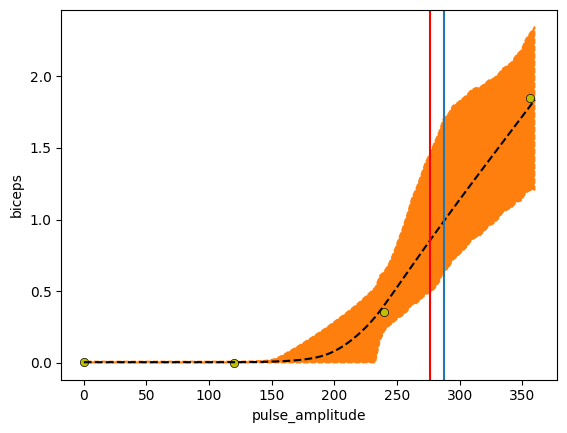

In [208]:
sns.lineplot(x=temp_pred_df[model.intensity], y=curr_mu_posterior_mean[:, 0], color="k", linestyle="dashed")
plt.fill_between(
    temp_pred_df[model.intensity],
    hpdi_mu_95[0, :, 0],
    hpdi_mu_95[1, :, 0],
    color="C1",
    linestyle="dashed"
)
sns.scatterplot(
    data=df,
    x=model.intensity,
    y=model.response[0],
    color="y",
    edgecolor="black"
)
plt.axvline(pred_df[model.intensity][argmax])
plt.axvline(df_full[model.intensity][argmin], color="r")

In [194]:
argmax

79

In [195]:
argmin

69

In [213]:
ind

[0, 30, 60, 69, 89]

In [218]:
ind_filter[argmin]

72

In [217]:
df_full[model.intensity][ind_filter].resetvalues

array([  4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.,
        48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,  88.,
        92.,  96., 100., 104., 108., 112., 116., 124., 128., 132., 136.,
       140., 144., 148., 152., 156., 160., 164., 168., 172., 176., 180.,
       184., 188., 192., 196., 200., 204., 208., 212., 216., 220., 224.,
       228., 232., 236., 244., 248., 252., 256., 260., 264., 268., 272.,
       276., 280., 284., 288., 292., 296., 300., 304., 308., 312., 316.,
       320., 324., 328., 332., 336., 340., 344., 348., 352.])

In [210]:
np.abs(df_full[model.intensity][ind_filter] - pred_df[model.intensity][argmax])

1     283.272727
2     279.272727
3     275.272727
4     271.272727
5     267.272727
         ...    
84     48.727273
85     52.727273
86     56.727273
87     60.727273
88     64.727273
Name: pulse_amplitude, Length: 86, dtype: float64

In [199]:
pred_df[model.intensity][argmax]

287.27272727272725

In [197]:
df_full[model.intensity][argmin]

276.0

In [202]:
df_full.pulse_amplitude[70:90]

70    280.0
71    284.0
72    288.0
73    292.0
74    296.0
75    300.0
76    304.0
77    308.0
78    312.0
79    316.0
80    320.0
81    324.0
82    328.0
83    332.0
84    336.0
85    340.0
86    344.0
87    348.0
88    352.0
89    356.0
Name: pulse_amplitude, dtype: float64

In [ ]:
np.abs(hpdi_mu_95 - curr_mu_posterior_mean[None, ...]).max(axis=0).argmax()

In [192]:
np.abs(hpdi_mu_95 - curr_mu_posterior_mean[None, ...]).max(axis=0).reshape(-1,).argmax()

99

In [17]:
df, encoder_dict = model.load(df)

2023-09-13 11:16:37,829 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 11:16:37,829 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 11:16:37,830 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 11:16:37,831 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [18]:
model.plot(df=df, encoder_dict=encoder_dict)

2023-09-13 11:16:39,386 - hbmep.dataset.core - INFO - Plotting dataset ...


2023-09-13 11:16:39,621 - hbmep.dataset.core - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/dataset.pdf
2023-09-13 11:16:39,621 - hbmep.utils.utils - INFO - func:plot took: 0.24 sec


In [19]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-09-13 11:16:41,156 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 11:16:49,276 - hbmep.utils.utils - INFO - func:run_inference took: 8.12 sec


In [154]:
obs.shape

(10, 90, 1)

In [20]:
mcmc.print_summary(prob=.95)



                mean       std    median      2.5%     97.5%     n_eff     r_hat
  H[0,0,0]      5.31      4.31      3.97      0.68     13.84  10133.07      1.00
  L[0,0,0]      0.01      0.00      0.01      0.00      0.01  10471.45      1.00
  a[0,0,0]    174.69      8.12    175.24    158.56    188.84  11181.13      1.00
  b[0,0,0]      0.05      0.04      0.04      0.00      0.13   7635.79      1.00
g_1[0,0,0]     68.10     46.92     57.94      0.59    160.79   7898.05      1.00
g_2[0,0,0]      1.03      0.70      0.90      0.00      2.36  12838.31      1.00
  v[0,0,0]      8.92      7.19      7.16      0.00     23.00   7346.79      1.00
  µ_a[0,0]    167.47     28.75    170.38    106.38    225.07   7577.30      1.00
  σ_H[0,0]      5.36      2.95      4.86      0.77     11.13  10448.30      1.00
  σ_L[0,0]      0.02      0.02      0.02      0.00      0.07  13094.44      1.00
  σ_a[0,0]     34.85     26.94     28.86      0.54     88.32   8499.37      1.00
  σ_b[0,0]      0.08      0

In [21]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-09-13 11:16:53,055 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-13 11:16:54,239 - hbmep.utils.utils - INFO - func:predict took: 1.18 sec
2023-09-13 11:16:54,244 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-13 11:16:54,551 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/recruitment_curves.pdf
2023-09-13 11:16:54,551 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.50 sec


In [22]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-09-13 11:16:56,304 - hbmep.model.baseline - INFO - Generating predictions ...


2023-09-13 11:16:57,472 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
2023-09-13 11:16:57,479 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-13 11:16:58,022 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/posterior_predictive_check.pdf
2023-09-13 11:16:58,024 - hbmep.utils.utils - INFO - func:render_predictive_check took: 1.72 sec


In [24]:
numpyro_data = az.from_numpyro(mcmc)

loo_score = az.loo(numpyro_data)
print(f"ELPD LOO (Log): {loo_score.elpd_loo:.2f}")

waic_score = az.waic(numpyro_data)
print(f"ELPD WAIC (Log): {waic_score.elpd_waic:.2f}")



ELPD LOO (Log): 21.18
ELPD WAIC (Log): 22.31


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [1]:
posterior_samples_true[site.a][0, ...]


NameError: name 'posterior_samples_true' is not defined